In [14]:
import requests
from io import BytesIO
from PIL import Image
import os

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output
import ipywidgets as widgets

import pandas as pd
import numpy as np

import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from DataHandlers import ImageDataset, InMemDataLoader

In [29]:
class Wrapper():
    def __init__(
                self, 
                model, 
                paths = {'train': 'data/train.csv', 'submit': 'data/submit.csv', 'small': 'data/small.csv'},
                transform = None,
                batch_size = 20,
            ):
        
        self.model = model
        self.batch_size = batch_size
        
        if transform is None:
            transform = T.Compose([
                T.Resize(80),
                T.CenterCrop(60),
                T.ToTensor(),
                T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        train = pd.read_csv(paths['train'])  
        n = len(train)
        
        submit = pd.read_csv(paths['submit'])
        self.max_submit_id = 22661
        
        small = pd.read_csv(paths['small'])
        
        dataset_types = ['train', 'valid', 'test', 'submit', 'small']        
        self.datasets = {
            'train'  : ImageDataset(train[:int(n * 0.8)], transform=transform),
            'valid'  : ImageDataset(train[int(n * 0.8):int(n * 0.9)], transform=transform),
            'test'   : ImageDataset(train[int(n * 0.9):], transform=transform),
            'small' : ImageDataset(small, transform=transform),
            'submit' : ImageDataset(submit, transform=transform)
        }
        
        self.loaders = {
            dataset_type: DataLoader(dataset, self.batch_size, shuffle=(dataset_type=='train' or dataset_type=='small'))
            for dataset_type, dataset in self.datasets.items()
        } 
        
    def train(self, loader='small'):
        print('Started training model')
        self.model.train(self.loaders[loader])
        print('Finished training model\n')
        
    def fscore(self, sample_size=100):
        def _count(loader):
            preds, truth = [], []
            items_count = 0
            for images1, images2, equals in loader:
                preds.append(self.model.predict(images1, images2))
                truth.append(equals)
                items_count += self.batch_size
                if items_count > sample_size: break

            preds = torch.cat(preds)
            truth = torch.cat(truth)

            preds_bin = (preds > 0.5).int()
            f1 = f1_score(truth.numpy(), preds_bin.numpy())
            return f1
    
        print('Started calculating f-score')
        print(f'Train       : {_count(self.loaders["train"]): .3f}%')
        print(f'Small train : {_count(self.loaders["small"]): .3f}%')
        print(f'Validation  : {_count(self.loaders["valid"]): .3f}%') 
        print(f'Test        : {_count(self.loaders["test"]): .3f}%\n') 
    
    def _test_loaders(self):
        print('Examples of images from the supported loaders:')
        to_show = {}
        for loader_type, loader in self.loaders.items():
            image1, image2, _ = next(iter(loader))
            image1 = image1[0]
            image2 = image2[0]
            to_show[loader_type + '-1'] = image1
            to_show[loader_type + '-2'] = image2
        num_images = len(to_show)
        fig, axs = plt.subplots(1, num_images, figsize=(15, 15))

        for i, (name, img) in enumerate(to_show.items()):
            axs[i].imshow(img.numpy().transpose(1,2,0).clip(0, 254), cmap='gray')
            axs[i].set_title(name)
            axs[i].axis('off')

        plt.show()

    def mislabeled(self, loader='train'):
        loader = self.loaders[loader]

        def mislabeled_inner():
            for images1, images2, equal in loader:
                preds = self.model.predict(images1, images2)
                if (preds == equal).all(): 
                    continue
                else:
                    for index in (preds != equal).nonzero():
                        yield (images1[index], images2[index], preds[index], equal[index])

        button = widgets.Button(description="Next Images")
        output = widgets.Output()

        def on_button_clicked(b):
            with output:
                clear_output()
                image1, image2, pred, truth = next(mislabeled_gen)
                def torch2np(x): return x.squeeze().numpy().transpose(1,2,0).clip(0,244)
                image1 = torch2np(image1)
                image2 = torch2np(image2)
                print(np.abs(image1 - image2).mean())
                fig, axs = plt.subplots(1, 3, figsize=(14,7))
                axs[0].imshow(image1)
                axs[1].imshow(image2)
                axs[2].imshow(np.abs(image1 - image2))
                fig.suptitle(f'Predicted: {pred.item()}\nTruth: {truth.item()}')
                plt.show()

        button.on_click(on_button_clicked)
        display(button, output)
        mislabeled_gen = mislabeled_inner()
        on_button_clicked(None)  # show the first images
        
    def save_test_preds(self, path='res.csv'):
        print(f'Started saving test predictions to {path}')
        ids = []
        preds = []
            
        for images1, images2, id_ in tqdm(self.loaders['submit']):
            preds.extend(self.model.predict(images1, images2))
            ids.extend(id_)
            
        all_ids = pd.DataFrame({
            'ID': range(2, self.max_submit_id + 1),
        })
        res = pd.DataFrame({
            'ID': [obj.item() for obj in ids],
            'is_same': [obj.item() for obj in preds]
        }).drop_duplicates()

        res = all_ids.merge(res, on='ID', how='left').fillna(0)
        res.to_csv(path, index=False)
        print(f'Saved test predictions to {path}\n')

In [30]:
class ThresholdClassifier():
    def __init__(self):
        pass
    
    def train(self, loader):
        pass
    
    def predict(self, images1, images2):
        delta = ((images1 - images2).abs()).mean(dim=(1,2,3))
        return (delta < 0.13).int()

Examples of images from the supported loaders:


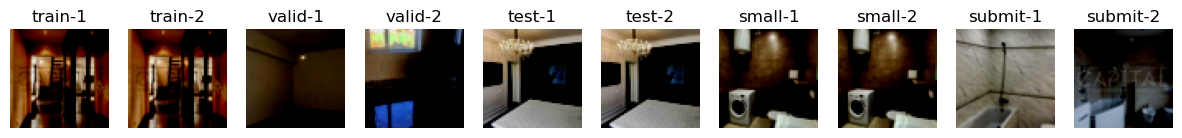

Started training model
Finished training model

Started calculating f-scores
Train       :  0.963%
Small train :  0.923%
Validation  :  0.971%
Test        :  1.000%



Button(description='Next Images', style=ButtonStyle())

Output()

In [28]:
model = ThresholdClassifier()
wrapper = Wrapper(model)
wrapper._test_loaders()
wrapper.train(loader='small')
wrapper.fscore(sample_size=300, loader='small')
wrapper.mislabeled(loader='small')